### Define imports

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from transformers import AutoTokenizer
import json
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, PageBreak
)
from reportlab.lib.units import inch
from xml.sax.saxutils import escape
from matplotlib.patches import Patch
from matplotlib import rcParams


# Set global plotting style
def set_paper_style(use_tex=False):
    # If you compile with LaTeX and want perfect matching fonts, set use_tex=True
    rcParams.update({

        # --- Sizes (tune these to taste) ---
        "font.size": 12,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "legend.title_fontsize": 13,

        # --- Lines / spines ---
        "axes.linewidth": 1.0,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,

        # --- Grid ---
        "axes.grid": False,                # enable per-axis (so we can do y-only)
        "grid.linestyle": "--",
        "grid.linewidth": 0.8,
        "grid.alpha": 0.35,

        # --- Savefig (PDF-friendly) ---
        "savefig.bbox": "tight",
        "savefig.dpi": 300,
        "pdf.fonttype": 42,   # keep text editable in vector editors
        "ps.fonttype": 42,
    })


### Visualize GSM8k accuracy results

No Gen Accuracies: {'no_gen_qwen3-1.7b_sol': 94.21052631578948, 'no_gen_qwen3-4b_sol': 97.90575916230367, 'no_gen_rlad_sol': 93.54838709677419}
RLAD Gen Accuracies: {'rlad_gen_qwen3-1.7b_sol': 91.39784946236558, 'rlad_gen_qwen3-4b_sol': 97.38219895287958, 'rlad_gen_rlad_sol': 95.16129032258065}
Unique Solvers: ['qwen3-1.7b_sol', 'qwen3-4b_sol', 'rlad_sol']


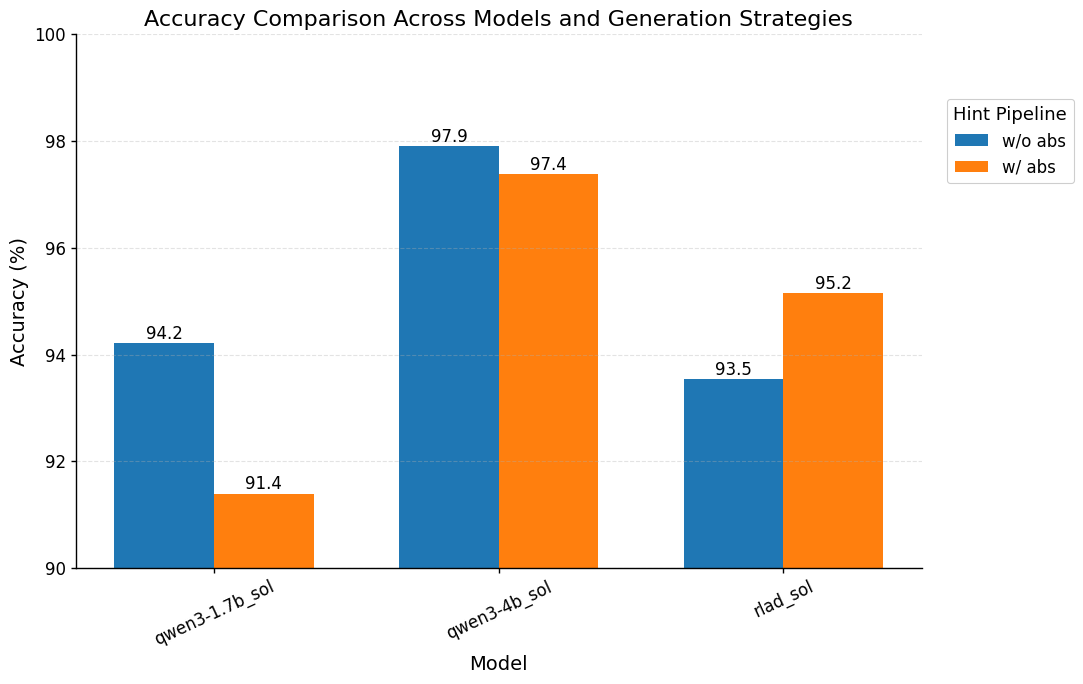

In [55]:
path_to_results = '../runs/gsm8k/summary.json'

with open(path_to_results, 'r') as f:
    results = json.load(f)

complete_results = results['aggregate']
models = list(complete_results.keys())
no_gen_acc = {
    mod: 100 * complete_results[mod]["overall"]["accuracy"] for mod in models if "no_gen" in mod
}
rlad_gen_acc = {
    mod: 100 * complete_results[mod]["overall"]["accuracy"] for mod in models if "rlad_gen" in mod
}
print("No Gen Accuracies:", no_gen_acc)
print("RLAD Gen Accuracies:", rlad_gen_acc)

# Create plots directory if it doesn't exist
os.makedirs("../plots/", exist_ok=True)

# Plot settings
unique_solvers = sorted(list({mod.replace("no_gen_", "") for mod in no_gen_acc.keys()}))

print("Unique Solvers:", unique_solvers)
x = np.arange(len(models) // 2)
width = 0.35

set_paper_style(use_tex=False)
fig, ax = plt.subplots(figsize=(11, 7))
bars1 = ax.bar(x - width/2, list(no_gen_acc.values()), width, label="w/o abs")
bars2 = ax.bar(x + width/2, list(rlad_gen_acc.values()), width, label="w/ abs")

# Labels & styling
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Model")
ax.set_title("Accuracy Comparison Across Models and Generation Strategies")
ax.set_xticks(x)
ax.set_xticklabels(unique_solvers, rotation=25)
ax.set_ylim(90, 100.0)

# Annotate bars with percentages
for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.002,
            f"{height:.1f}",
            ha="center",
            va="bottom"
        )
# Style: light y-grid only, remove top/right spines
ax.grid(True, axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

leg = ax.legend(title="Hint Pipeline", frameon=True, 
    loc="center left",
    bbox_to_anchor=(1.02, 0.8))
leg.get_frame().set_alpha(0.95)
leg.get_frame().set_linewidth(0.8)
fig.savefig("../plots/gsm8k_accuracy_comparison.png", dpi=300, bbox_inches='tight')
fig.tight_layout()
plt.show()


### Calculate the average number of tokens per generated solution

In [56]:
path_to_outputs = '../runs/gsm8k/outputs.jsonl'

# Initialize tokenizers once
toks = {}
toks["CMU-AIRe/RLAD-Sol-Gen"] = tok = AutoTokenizer.from_pretrained("CMU-AIRe/RLAD-Sol-Gen", trust_remote_code=True)
toks["Qwen/Qwen3-1.7B"] = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B", trust_remote_code=True)
toks["Qwen/Qwen3-4B"] = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B", trust_remote_code=True)

toks_counts = {}

with open('../runs/gsm8k/outputs.jsonl', 'r') as f:
    for line in f:
        ex = json.loads(line)
        model_id = ex['solver_model_id']
        pipeline = ex['pipeline']
        if pipeline not in toks_counts:
            toks_counts[pipeline] = []
        example_idxs = ex["row_idx"]
        model_output = ex['solver_output']
        n_toks = len(toks[model_id].tokenize(model_output))
        toks_counts[pipeline].append((n_toks, example_idxs))
        

### Plot GSM8k statistics on trancated responses

No Gen Truncated: {'no_gen_qwen3-1.7b_sol': 5.0, 'no_gen_qwen3-4b_sol': 4.5, 'no_gen_rlad_sol': 7.0}
RLAD Gen Truncated: {'rlad_gen_qwen3-1.7b_sol': 7.0, 'rlad_gen_qwen3-4b_sol': 4.5, 'rlad_gen_rlad_sol': 7.0}
Unique Solvers: ['qwen3-1.7b_sol', 'qwen3-4b_sol', 'rlad_sol']


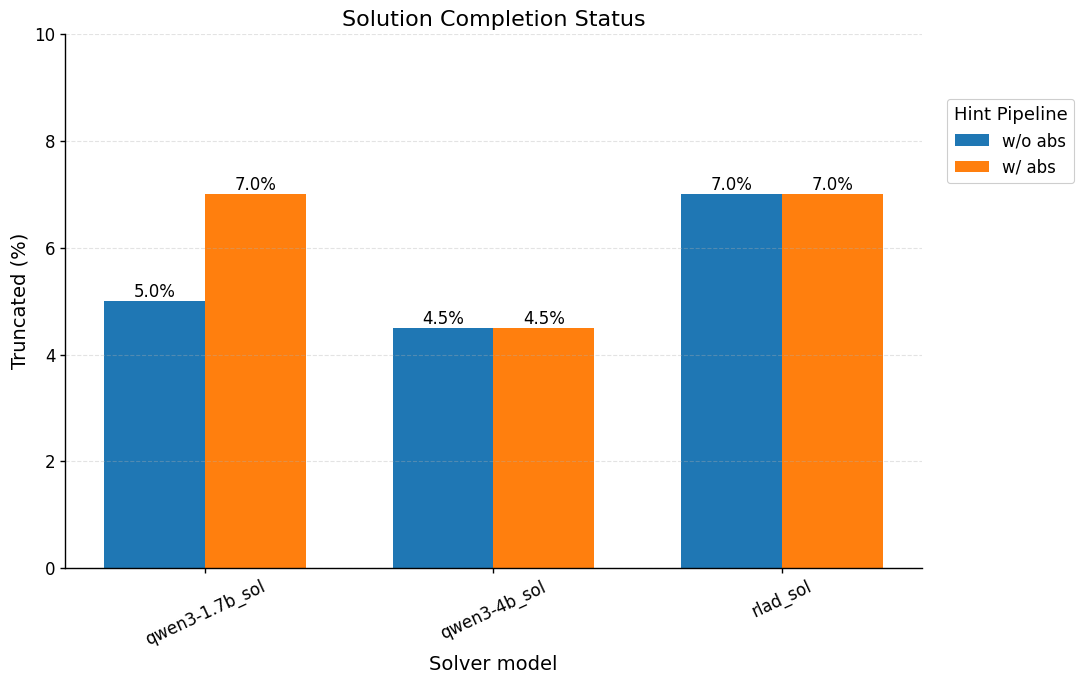

In [57]:
num_examples = results["selected"]["n_total"]

no_gen_trunc = {
    mod: 100 * (complete_results[mod]["overall"]["truncated"] + 2.0) / float(num_examples) for mod in models if "no_gen" in mod
}
rlad_gen_trunc = {
    mod: 100 * (complete_results[mod]["overall"]["truncated"] + 2.0) / float(num_examples) for mod in models if "rlad_gen" in mod
}
print("No Gen Truncated:", no_gen_trunc)
print("RLAD Gen Truncated:", rlad_gen_trunc)

# Create plots directory if it doesn't exist
os.makedirs("../plots/", exist_ok=True)

# Plot settings
unique_solvers = sorted(list({mod.replace("no_gen_", "") for mod in no_gen_trunc.keys()}))

print("Unique Solvers:", unique_solvers)
x = np.arange(len(models) // 2)
width = 0.35

set_paper_style(use_tex=False)


fig, ax = plt.subplots(figsize=(11, 7))
bars1 = ax.bar(x - width/2, list(no_gen_trunc.values()), width, label="w/o abs")
bars2 = ax.bar(x + width/2, list(rlad_gen_trunc.values()), width, label="w/ abs")
# Labels & styling
ax.set_ylabel("Truncated (%)")
ax.set_xlabel("Solver model")
ax.set_title(f"Solution Completion Status")
ax.set_xticks(x)
ax.set_xticklabels(unique_solvers, rotation=25)
ax.set_ylim(0, 10.0)
ax.legend()

# Annotate bars with percentages
for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.002,
            f"{height:.1f}%",
            ha="center",
            va="bottom"
        )

# Style: light y-grid only, remove top/right spines
ax.grid(True, axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

leg = ax.legend(title="Hint Pipeline", frameon=True, 
    loc="center left",
    bbox_to_anchor=(1.02, 0.8))
leg.get_frame().set_alpha(0.95)
leg.get_frame().set_linewidth(0.8)
fig.savefig("../plots/gsm8k_truncated_comparison.pdf", bbox_inches='tight')
fig.tight_layout()
plt.show()

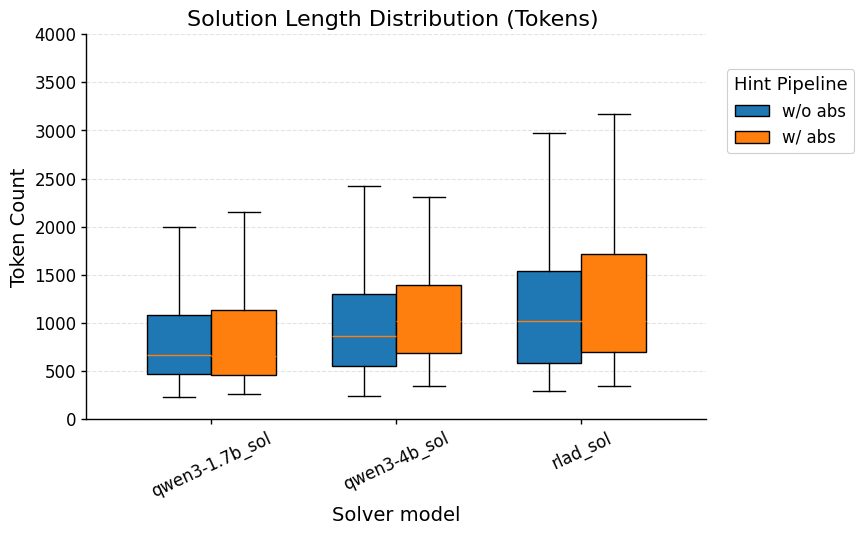

In [58]:
num_examples = results["selected"]["n_total"]

# Create plots directory if it doesn't exist
os.makedirs("../plots/", exist_ok=True)

# Consistent solver order
unique_solvers = sorted(
    mod.replace("no_gen_", "") for mod in toks_counts if "no_gen" in mod
)
x = np.arange(len(unique_solvers))
width = 0.35

set_paper_style(use_tex=False)

fig, ax = plt.subplots(figsize=(8, 5))

# Collect raw token counts
no_gen_data = [
    [n_toks for n_toks, _ in toks_counts[f"no_gen_{s}"]]
    for s in unique_solvers
]
rlad_data = [
    [n_toks for n_toks, _ in toks_counts[f"rlad_gen_{s}"]]
    for s in unique_solvers
]

# Box plots
bp1 = ax.boxplot(
    no_gen_data,
    positions=x - width / 2,
    widths=width,
    patch_artist=True,
    showfliers=False
)

bp2 = ax.boxplot(
    rlad_data,
    positions=x + width / 2,
    widths=width,
    patch_artist=True,
    showfliers=False
)

# Coloring (minimal, clean)
for box in bp1["boxes"]:
    box.set(facecolor= "#1f77b4", alpha=1)
for box in bp2["boxes"]:
    box.set(facecolor="#ff7f0e", alpha=1)

# Labels & styling
ax.set_ylabel("Token Count")
ax.set_xlabel("Solver model")
ax.set_title(
    f"Solution Length Distribution (Tokens) "
)
ax.set_xticks(x)
ax.set_xticklabels(unique_solvers, rotation=25)
ax.set_ylim(0, 4000)


# Style: light y-grid only, remove top/right spines
ax.grid(True, axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

leg = ax.legend(
    [bp1["boxes"][0], bp2["boxes"][0]],
    ["w/o abs", "w/ abs"],
    title="Hint Pipeline",

    loc="center left",
    bbox_to_anchor=(1.02, 0.8)
)
leg.get_frame().set_alpha(0.95)
leg.get_frame().set_linewidth(0.8)
fig.savefig("../plots/gsm8k_token_distribution_boxplot.pdf", bbox_inches="tight")
plt.show()

### Plot statistics on number of tokens per response

No Gen Tokens: {'no_gen_qwen3-1.7b_sol': 881.6315789473684, 'no_gen_qwen3-4b_sol': 1067.2460732984293, 'no_gen_rlad_sol': 1293.97311827957}
RLAD Gen Tokens: {'rlad_gen_qwen3-1.7b_sol': 976.1505376344086, 'rlad_gen_qwen3-4b_sol': 1173.261780104712, 'rlad_gen_rlad_sol': 1327.8387096774193}
Unique Solvers: ['qwen3-1.7b_sol', 'qwen3-4b_sol', 'rlad_sol']


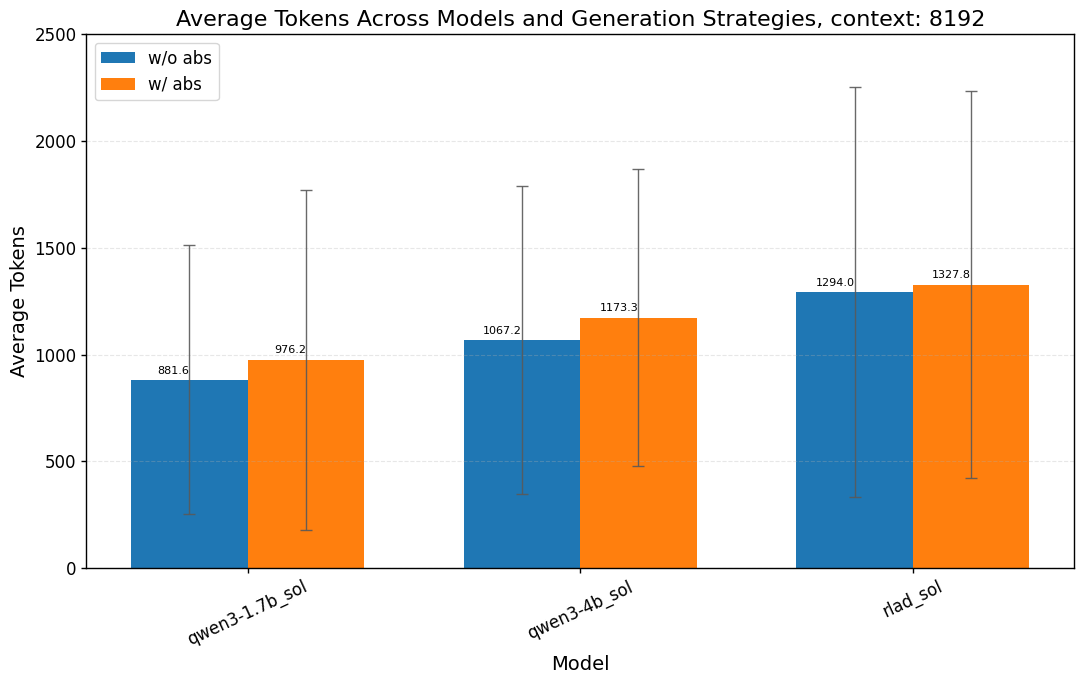

In [59]:
num_examples = results["selected"]["n_total"]

no_gen_toks = {pipe: np.mean([n_toks for n_toks, _ in toks_counts[pipe]]) for pipe in toks_counts if "no_gen" in pipe}

rlad_gen_toks = {pipe: np.mean([n_toks for n_toks, _ in toks_counts[pipe]]) for pipe in toks_counts if "rlad_gen" in pipe}

no_gen_toks_stds = {pipe: np.std([n_toks for n_toks, _ in toks_counts[pipe]]) for pipe in toks_counts if "no_gen" in pipe}

rlad_gen_toks_stds = {pipe: np.std([n_toks for n_toks, _ in toks_counts[pipe]]) for pipe in toks_counts if "rlad_gen" in pipe}


print("No Gen Tokens:", no_gen_toks)
print("RLAD Gen Tokens:", rlad_gen_toks)

# Create plots directory if it doesn't exist
os.makedirs("../plots/", exist_ok=True)

# Plot settings
unique_solvers = sorted(list({mod.replace("no_gen_", "") for mod in no_gen_toks.keys()}))

print("Unique Solvers:", unique_solvers)
x = np.arange(len(models) // 2)
width = 0.35

set_paper_style(use_tex=False)
fig, ax = plt.subplots(figsize=(11, 7))

error_kw = dict(
    ecolor="0.35",      
    elinewidth=1.0,
    capthick=1.0,
    alpha=0.9
)

bars1 = ax.bar(x - width/2, list(no_gen_toks.values()), width,  yerr=list(no_gen_toks_stds.values()), capsize=4, error_kw= error_kw, label="w/o abs")
bars2 = ax.bar(x + width/2, list(rlad_gen_toks.values()), width, yerr=list(rlad_gen_toks_stds.values()), capsize=4, error_kw= error_kw, label="w/ abs")   
      
# Labels & styling
ax.set_ylabel("Average Tokens")
ax.set_xlabel("Model")
ax.set_title(f"Average Tokens Across Models and Generation Strategies, context: {results['gen_cfg']['max_context_tokens']}")
ax.set_xticks(x)
ax.set_xticklabels(unique_solvers, rotation=25)
ax.set_ylim(0, 2500.0)
ax.legend()

# Annotate bars with percentages
for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 20,
            f"{height:.1f}",
            ha="right",
            va="bottom",
            fontsize= 8
        )
ax.grid(True, axis="y", alpha=0.3)

fig.savefig("../plots/gsm8k_average_tokens_comparison.pdf", dpi=300, bbox_inches='tight')
fig.tight_layout()
plt.show()

### Extract results for HMMT25
* pass@k and vote acc

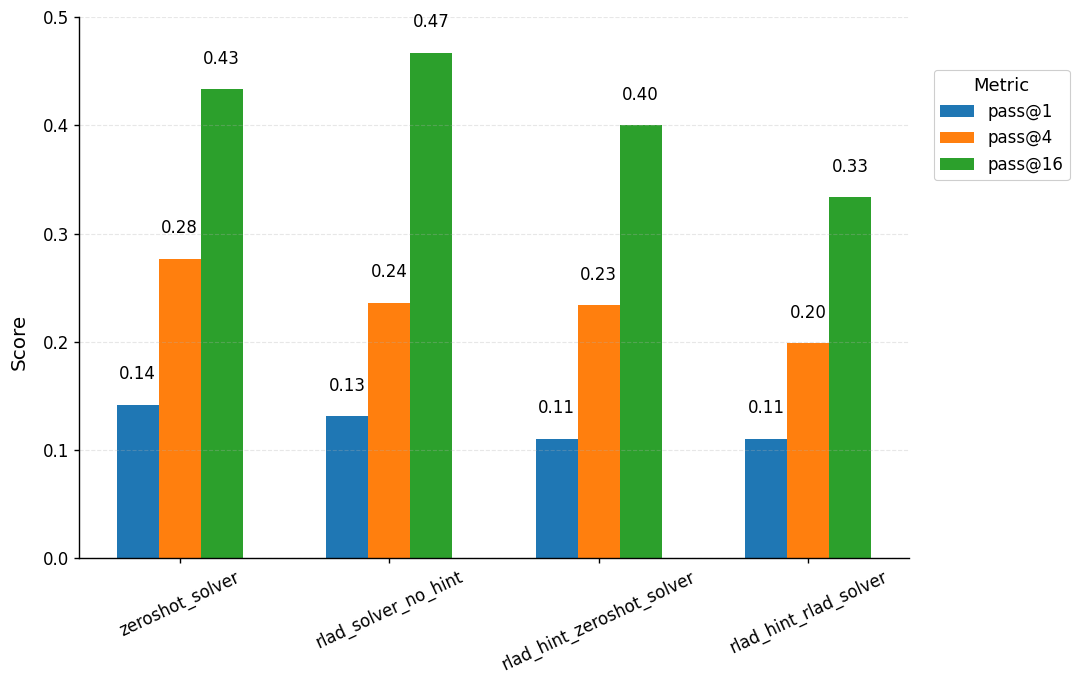

In [60]:
results_path = '../runs/hmmt25/summary_pass@k.json'

with open(results_path, 'r') as f:
    results = json.load(f)


pipelines = [
    "zeroshot_solver",
    "rlad_solver_no_hint",
    "rlad_hint_zeroshot_solver",
    "rlad_hint_rlad_solver",
]

colors = {
    "pass@1": "#1f77b4",   # blue
    "pass@4": "#ff7f0e",   # orange
    "pass@16": "#2ca02c",  # green
}


legend_handles = [
    Patch(facecolor=colors["pass@1"], label="pass@1"),
    Patch(facecolor=colors["pass@4"], label="pass@4"),
    Patch(facecolor=colors["pass@16"], label="pass@16"),
]

x = np.arange(len(pipelines))
metrics = ["pass@1_est_from_n", "pass@4_est_from_n", "pass@16_est_from_n"]  # plot these side-by-side

set_paper_style(use_tex=False)
fig, axes = plt.subplots(1, 1, figsize=(11, 7), sharey=True)

bar_w = 0.2


for i, pipe in enumerate(pipelines):
    temp_pipe = results[pipe]

    # Extract metric values for n=1 and n=4 (keys are strings in your dict)
    vals = {m: temp_pipe[m]  for m in metrics}

    axes.bar(x[i] - bar_w, np.array(vals["pass@1_est_from_n"]), width=bar_w, color=colors["pass@1"])
    axes.bar(x[i] , np.array(vals["pass@4_est_from_n"]),  width=bar_w, color=colors["pass@4"])
    axes.bar(x[i] + bar_w, np.array(vals["pass@16_est_from_n"]),  width=bar_w, color=colors["pass@16"])

    
    axes.set_xticks(x)
    axes.set_xticklabels(pipelines, rotation=25)
    axes.set_ylim(0.0, 0.5)
    axes.grid(True, axis="y", alpha=0.3)
    
    axes.text(x[i] - bar_w, vals["pass@1_est_from_n"] + 0.02, f"{vals['pass@1_est_from_n']:.2f}",
            ha="center", va="bottom")
    axes.text(x[i] , vals["pass@4_est_from_n"] + 0.02, f"{vals['pass@4_est_from_n']:.2f}",
            ha="center", va="bottom")
    axes.text(x[i] + bar_w, vals["pass@16_est_from_n"] + 0.02, f"{vals['pass@16_est_from_n']:.2f}",
            ha="center", va="bottom")



fig.supylabel("Score")

# Put one legend for the whole figure
handles, labels = axes.get_legend_handles_labels()
# Style: light y-grid only, remove top/right spines
axes.grid(True, axis="y")
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)

leg = axes.legend(
    legend_handles,
    ["pass@1", "pass@4", "pass@16"],
    title="Metric",
    loc="center left",
    bbox_to_anchor=(1.02, 0.8)
)
leg.get_frame().set_alpha(0.95)
leg.get_frame().set_linewidth(0.8)

fig.tight_layout()
fig.savefig("../plots/hmmt25_pipeline_comparison.pdf", bbox_inches='tight')
plt.show()

### Print some examples from HMMT25

In [65]:

def ptext(s: str) -> str:
    # Escape &, <, > so ReportLab doesn't treat them as tags
    s = "" if s is None else str(s)
    s = escape(s)
    # Convert newlines to <br/> after escaping
    return s.replace("\n", "<br/>")

def read_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                yield json.loads(line)

def safe(x, default=""):
    return default if x is None else str(x)

def truncate(s, n=400):
    s = safe(s)
    return s if len(s) <= n else s[: n - 1] + "…"

def export_outputs_pdf(
    jsonl_path: str,
    pdf_path: str,
    max_rows: int | None = None,
    detail_pages_for: str = "incorrect",  # "incorrect" or "all"
):
    styles = getSampleStyleSheet()
    title_style = styles["Title"]
    normal = styles["BodyText"]
    
    mono_style = ParagraphStyle(
        "mono",
        parent=normal,
        fontName="Courier",
        fontSize=8.5,
        leading=10.5,
    )

    # Landscape letter looks good for wide tables
    doc = SimpleDocTemplate(
        pdf_path,
        pagesize=landscape(letter),
        leftMargin=0.5 * inch,
        rightMargin=0.5 * inch,
        topMargin=0.45 * inch,
        bottomMargin=0.5 * inch,
        title="Model Outputs Report",
    )

    elements = []

    # --- Load rows ---
    rows = []
    for ex in read_jsonl(jsonl_path):
        rows.append(ex)
        if max_rows is not None and len(rows) >= max_rows:
            break

    # --- Header ---
    elements.append(Paragraph("Model Outputs Report", title_style))
    elements.append(Paragraph(f"Source: {safe(jsonl_path)}", normal))
    elements.append(Paragraph(f"Number of Examples: {len(rows)}", normal))
    elements.append(Spacer(1, 10))

    # --- Detail pages ---
    elements.append(PageBreak())
    elements.append(Paragraph("Details", title_style))
    elements.append(Spacer(1, 8))

    for ex in rows:
        if detail_pages_for == "incorrect" and ex.get("correct", False):
            continue

        ch = ex.get("abstractions", "")[0]
        ch = ch.strip() if ch and ch.strip() else "(none)"

        gt_full = ex.get("ground_truth_answer", "")
        gt_full = gt_full.strip() if gt_full else "(none)"

        sol = ex.get("solutions", "")[0][0]
        
        sol = sol.strip() if sol else "(none)"

        elements.append(Paragraph(
            f"Question: {ptext(ex.get('row_idx'))} • "
            f"{'Correct' if ex.get('correct') else 'Incorrect'}",
            styles["Heading2"]
        ))

        elements.append(Paragraph(
            f"<b>Hint:</b> {ptext(ex.get('hint_model_id')) if ex.get('hint_model_id') else 'None'}", normal
        ))
        elements.append(Paragraph(
            f"<b>Model:</b> {ptext(ex.get('solver_model_id'))}", normal
        ))
        elements.append(Paragraph(
            f"<b>GT:</b> {ptext(ex.get('ground_truth_answer'))} "
            f"&nbsp;&nbsp; <b>Pred:</b> {ptext(ex.get('pred_extracted'))}",
            normal,
        ))

        elements.append(Spacer(1, 6))

        elements.append(Paragraph("<b>Question</b>", styles["Heading3"]))
        elements.append(Paragraph(ptext(ex.get("question", "")), normal))

        elements.append(Spacer(1, 6))
        elements.append(Paragraph("<b>Cheatsheet</b>", styles["Heading3"]))
        elements.append(Paragraph(ptext(ch), normal))

        elements.append(Spacer(1, 6))
        elements.append(Paragraph("<b>Ground Truth (full)</b>", styles["Heading3"]))
        elements.append(Paragraph(ptext(gt_full), normal))

        elements.append(Spacer(1, 6))
        elements.append(Paragraph("<b>Solver Output</b>", styles["Heading3"]))
        elements.append(Paragraph(ptext(sol), mono_style))

        elements.append(PageBreak())


    doc.build(elements)
    print(f"Wrote: {pdf_path}")

In [66]:
export_outputs_pdf(
    jsonl_path= "../runs/hmmt25/records.jsonl",
    pdf_path= "../runs/hmmt25/outputs_report.pdf",
    detail_pages_for= "all"  # "incorrect" or "all"
)

Wrote: ../runs/hmmt25/outputs_report.pdf


### Calculate the number of tokens per response

In [143]:
path_to_outputs = '../runs/hmmt25/records.jsonl'


# Initialize tokenizers once
toks = {}
toks["CMU-AIRe/RLAD-Sol-Gen"] = tok = AutoTokenizer.from_pretrained("CMU-AIRe/RLAD-Sol-Gen", trust_remote_code=True)
toks["Qwen/Qwen3-1.7B"] = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B", trust_remote_code=True)
toks["Qwen/Qwen3-4B"] = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B", trust_remote_code=True)

toks_counts = {}
eos_counts = {}
hit_max_token_counts = {}
sols_counts = {}
with open('../runs/hmmt25/records.jsonl', 'r') as f:
    for line in f:
        ex = json.loads(line)
        flattened_solutions = np.asarray(ex['solutions']).flatten()
        eos_meta = np.asarray(ex['solutions_meta'])[:, :, 0].flatten()
        hit_max_tokens = np.asarray(ex['solutions_meta'])[:, :, 1].flatten()
        
        eos_solutions = flattened_solutions[eos_meta == 1]
        hit_max_token_solutions = flattened_solutions[hit_max_tokens == 1]
        

        model_id = ex['solver_model_id']
        pipeline = ex['pipeline']
        if pipeline not in toks_counts:
            toks_counts[pipeline] = []
            eos_counts[pipeline] = 0
            hit_max_token_counts[pipeline] = 0
            sols_counts[pipeline] = 0
        
        for sol in flattened_solutions:
            n_toks = len(toks[model_id].tokenize(sol))
            toks_counts[pipeline].append(n_toks)
        
        eos_counts[pipeline] += len(eos_solutions)
        hit_max_token_counts[pipeline] += len(hit_max_token_solutions)
        
        sols_counts[pipeline] += len(flattened_solutions)


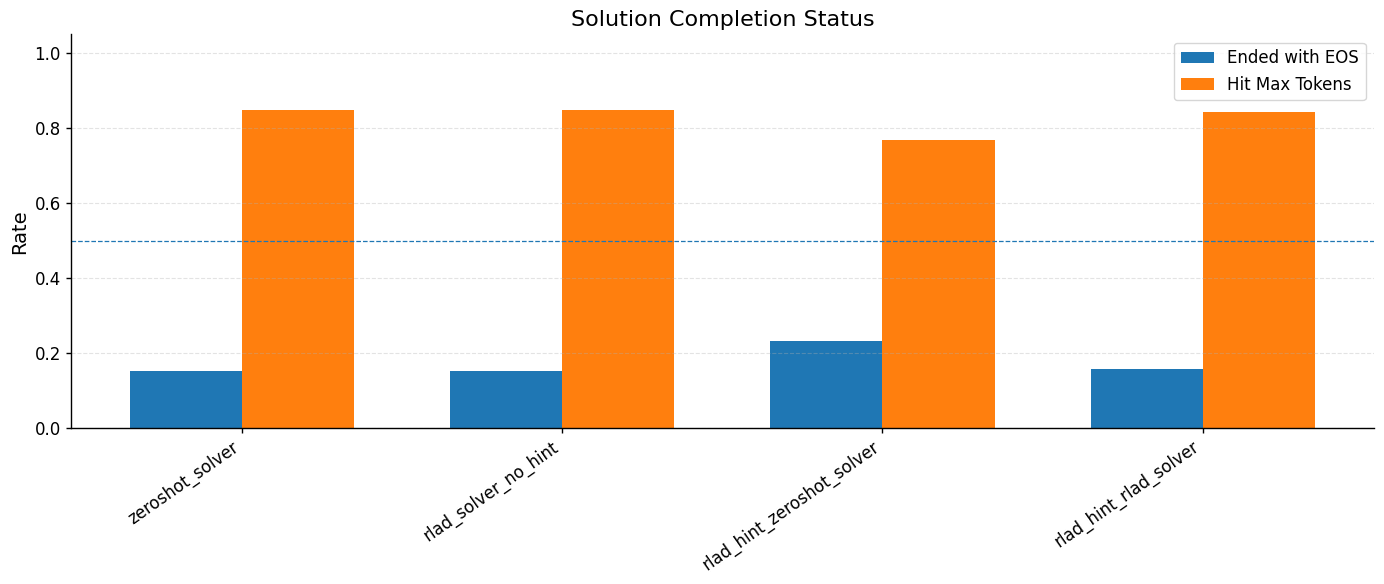

In [166]:
pipelines_order = [
    "zeroshot_solver",
    "rlad_solver_no_hint",
    "rlad_hint_zeroshot_solver",
    "rlad_hint_rlad_solver",
]
# Convert to rates
ended_rate = [eos_counts[p] / sols_counts[p] if sols_counts[p] else 0.0 for p in pipelines_order]
hit_rate   = [hit_max_token_counts[p] / sols_counts[p] if sols_counts[p] else 0.0 for p in pipelines_order]

# ----------------------------
# Plot: bar (completion status) + boxplot (length distribution)
# ----------------------------
set_paper_style(use_tex=False)
fig, ax1 = plt.subplots(
    1, 1, figsize=(14, 6)
)

# ---- Left: grouped bars (completion status) ----
x = np.arange(len(pipelines_order))
bar_w = 0.35

ax1.bar(x - bar_w/2, ended_rate, width=bar_w, label="Ended with EOS")
ax1.bar(x + bar_w/2, hit_rate,   width=bar_w, label="Hit Max Tokens")

# Optional reference line (as in your example)
ax1.axhline(0.5, linestyle="--", linewidth=0.9)

ax1.set_title("Solution Completion Status")
ax1.set_ylabel("Rate")
ax1.set_xticks(x)
ax1.set_xticklabels(pipelines_order, rotation=35, ha="right")
ax1.set_ylim(0, 1.05)
ax1.grid(True, axis="y")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.legend(loc="upper right", frameon=True)


plt.tight_layout()
plt.savefig("../plots/hmmt25_completion_and_length.pdf", bbox_inches="tight")
plt.show()

### HMMT-Feb25 over different problem types
* Change the $METRIC variable for the other pass@k variants

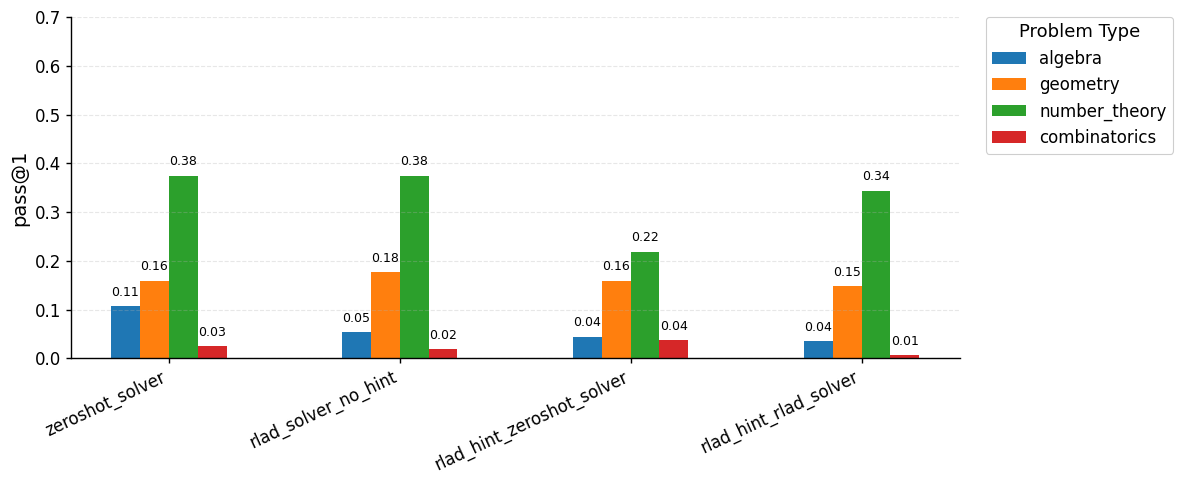

In [133]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

problem_types = ["algebra", "geometry", "number_theory", "combinatorics"]

pipelines = [
    "zeroshot_solver",
    "rlad_solver_no_hint",
    "rlad_hint_zeroshot_solver",
    "rlad_hint_rlad_solver",
]

colors = {
    "algebra": "#1f77b4",
    "geometry": "#ff7f0e",
    "number_theory": "#2ca02c",
    "combinatorics": "#d62728",
}

results_by_type = {}
for ptype in problem_types:
    path = f"../runs/hmmt25/summary_pass@k_{ptype}.json"
    with open(path, "r") as f:
        results_by_type[ptype] = json.load(f)

METRIC = "pass@1"  # or "pass@4", etc.

# Prepare plot data: rows=pipelines, cols=problem_types
passk = np.zeros((len(pipelines), len(problem_types)), dtype=float)
for j, ptype in enumerate(problem_types):
    for i, pipe in enumerate(pipelines):
        passk[i, j] = results_by_type[ptype][pipe][f"{METRIC}_est_from_n"]

# --- Better spacing defaults ---
x = np.arange(len(pipelines))  # 0,1,2,3 evenly spaced
n_types = len(problem_types)

group_width = 0.5                 # total width occupied by all bars in a group
bar_w = group_width / n_types      # each bar width
offsets = (np.arange(n_types) - (n_types - 1) / 2) * bar_w

set_paper_style(use_tex=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Draw bars + centered value labels
for j, ptype in enumerate(problem_types):
    bars = ax.bar(
        x + offsets[j],
        passk[:, j],
        width=bar_w,          # tiny gap between bars
        color=colors[ptype],
    )

    for rect, val in zip(bars, passk[:, j]):
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            rect.get_height() + 0.015,
            f"{val:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

ax.set_xticks(x)
ax.set_xticklabels(pipelines, rotation=25, ha="right")
ax.set_ylabel(METRIC)
ax.set_ylim(0, 0.7)

ax.grid(True, axis="y", alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

legend_handles = [Patch(facecolor=colors[ptype], label=ptype) for ptype in problem_types]
leg = ax.legend(
    handles=legend_handles,
    loc="center left",
    title="Problem Type",
    frameon=True,
    bbox_to_anchor=(1.02, 0.8),
)
leg.get_frame().set_alpha(0.95)
leg.get_frame().set_linewidth(0.8)

plt.tight_layout()
plt.savefig(f"../plots/hmmt25_{METRIC}_by_pipeline_problem_type.pdf", bbox_inches="tight")
plt.show()